# Analyzing Political Discourse in the 2024 U.S. Presidential Election  
### Sentiment Analysis (VADER) and Topic Modeling (LDA) on Twitter Data
## Project Overview

This project examines political discourse surrounding the **2024 U.S. Presidential Election** using a large corpus of Twitter data.  
The analysis combines:

- **Sentiment Analysis** using VADER
- **Topic Modeling** using Latent Dirichlet Allocation (LDA)

The goal is to understand:

- How sentiment is distributed across candidates
- Where political negativity and positivity concentrate
- How discussion volume interacts with sentiment
- How sentiment varies across discourse themes



## Libraries and Environment

This analysis uses standard Python libraries:

- `pandas`, `numpy` for data handling
- `re` for text preprocessing
- `vaderSentiment` for sentiment analysis
- `scikit-learn` for LDA topic modeling
- `matplotlib`, `seaborn` for visualization

All experiments are fully reproducible.


In [36]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


## Dataset Description

The dataset consists of approximately **50,000 English-language tweets** related to the 2024 U.S. election.

Each tweet includes:
- `text` — raw tweet content
- `username` — author handle
- `likeCount`, `quoteCount` — engagement metrics
- `date` — timestamp

All analyses are performed at the **tweet level**.


In [40]:
df = pd.read_csv("election.csv")
df.head()


,username,text,likeCount,quoteCount,date
0,SATraveler2,@MdBreathe continued- \nto develop a techniqu...,0.0,0.0,2024-11-20 23:59:59
1,JoeZumwalt,@UROCKlive1 all these banderite/nazi sycophant...,0.0,0.0,2024-11-20 23:59:57
2,67sharona,Laken Rileys Death Would Of Never Ever Happene...,1.0,0.0,2024-11-20 23:59:56
3,TruthAboutF,POV: you go downstairs in the middle of the ni...,14.0,0.0,2024-11-20 23:59:55
4,Hump98Clint,"@mtgreenee This is a good question, are you no...",1.0,0.0,2024-11-20 23:59:53


## Text Preprocessing Strategy

Different NLP tasks require **different preprocessing assumptions**.

- **VADER** relies on punctuation, capitalization, and emojis to detect sentiment.
- **LDA** requires normalized, noise-free text to identify semantic structure.

To avoid methodological errors, two separate cleaned text fields are created:

- `text_vader` — optimized for sentiment analysis
- `text_lda` — optimized for topic modeling


In [41]:
def is_english(text):
    return bool(re.search(r"[a-zA-Z]", str(text)))

df = df[df["text"].apply(is_english)].reset_index(drop=True)


##  Task-Specific Text Cleaning

### VADER-Safe Cleaning

For sentiment analysis, we retain:
- Capitalization
- Punctuation
- Emotional markers

Only URLs, excessive whitespace, and non-informative noise are removed.

This preserves the expressive structure needed for accurate sentiment scoring.


In [43]:
# VADER-safe minimal cleaning
def vader_clean(text):
    text = re.sub(r"http\S+|www\S+", "", str(text))  # remove URLs
    text = re.sub(r"@\w+", "", text)                 # remove mentions
    return text.strip()

df["text_vader"] = df["text"].apply(vader_clean)

df[["text", "text_vader"]].head(20)

,text,text_vader
0,@MdBreathe continued- \nto develop a techniqu...,continued- \nto develop a technique for hidin...
1,@UROCKlive1 all these banderite/nazi sycophant...,all these banderite/nazi sycophants to the dnc
2,Laken Rileys Death Would Of Never Ever Happene...,Laken Rileys Death Would Of Never Ever Happene...
3,POV: you go downstairs in the middle of the ni...,POV: you go downstairs in the middle of the ni...
4,"@mtgreenee This is a good question, are you no...","This is a good question, are you not a member ..."
5,The race is on for the next DNC chair. Martin ...,The race is on for the next DNC chair. Martin ...
6,@DefiyantlyFree Kamala Harris is a leech grift...,Kamala Harris is a leech grifter who has done ...
7,@BarronTrumpoo Kamala Harris is Vice President...,Kamala Harris is Vice President...we may not l...
8,@MayorOfLA @POTUS A Pew study this year fall s...,A Pew study this year fall showed that immigra...
9,@TheDemocrats Wtf are you doing Montana?,Wtf are you doing Montana?


### LDA-Safe Cleaning

For topic modeling, text is aggressively normalized by removing:
- URLs, mentions, hashtags
- Emojis and non-alphabetic characters
- Punctuation and extra whitespace

All text is converted to lowercase to improve topic coherence.


In [46]:

# LDA-safe aggressive cleaning
def lda_clean(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)   # remove URLs
    text = re.sub(r"@\w+", "", text)             # remove mentions
    text = re.sub(r"#\w+", "", text)             # remove hashtags
    text = re.sub(r"\d+", "", text)              # remove numbers
    text = re.sub(r"[^\x00-\x7F]+", " ", text)   # remove emojis & non-ASCII
    text = re.sub(r"[^\w\s]", "", text)          # remove punctuation
    text = re.sub(r"\s+", " ", text).strip()     # normalize whitespace
    return text


df["text_lda"] = df["text"].apply(lda_clean)
df[["text", "text_vader", "text_lda"]].head(20)



,text,text_vader,text_lda
0,@MdBreathe continued- \nto develop a techniqu...,continued- \nto develop a technique for hidin...,continued to develop a technique for hiding ev...
1,@UROCKlive1 all these banderite/nazi sycophant...,all these banderite/nazi sycophants to the dnc,all these banderitenazi sycophants to the dnc
2,Laken Rileys Death Would Of Never Ever Happene...,Laken Rileys Death Would Of Never Ever Happene...,laken rileys death would of never ever happene...
3,POV: you go downstairs in the middle of the ni...,POV: you go downstairs in the middle of the ni...,pov you go downstairs in the middle of the nig...
4,"@mtgreenee This is a good question, are you no...","This is a good question, are you not a member ...",this is a good question are you not a member o...
5,The race is on for the next DNC chair. Martin ...,The race is on for the next DNC chair. Martin ...,the race is on for the next dnc chair martin o...
6,@DefiyantlyFree Kamala Harris is a leech grift...,Kamala Harris is a leech grifter who has done ...,kamala harris is a leech grifter who has done ...
7,@BarronTrumpoo Kamala Harris is Vice President...,Kamala Harris is Vice President...we may not l...,kamala harris is vice presidentwe may not like...
8,@MayorOfLA @POTUS A Pew study this year fall s...,A Pew study this year fall showed that immigra...,a pew study this year fall showed that immigra...
9,@TheDemocrats Wtf are you doing Montana?,Wtf are you doing Montana?,wtf are you doing montana


Twitter data contains URLs, mentions, hashtags, and platform-specific noise.
These artifacts are removed to improve both sentiment and topic modeling performance.

## Sentiment Analysis Using VADER

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon-based sentiment analyzer designed for social media text.

It outputs a **compound score** in the range **[-1, 1]**, capturing overall emotional polarity.

Compound scores are categorized as:

- **Positive**: compound ≥ 0.05  
- **Neutral**: −0.05 < compound < 0.05  
- **Negative**: compound ≤ −0.05  

This discretization enables interpretable comparisons across groups.


In [47]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Compute compound sentiment score
df["vader_compound"] = df["text_vader"].apply(
    lambda x: analyzer.polarity_scores(str(x))["compound"]
)

# Classify sentiment using standard VADER thresholds
def vader_label(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df["vader_sentiment"] = df["vader_compound"].apply(vader_label)

# Quick sanity check
df[["text_vader", "vader_compound", "vader_sentiment"]].head(5)


,text_vader,vader_compound,vader_sentiment
0,continued- \nto develop a technique for hidin...,0.4019,Positive
1,all these banderite/nazi sycophants to the dnc,0.0000,Neutral
2,Laken Rileys Death Would Of Never Ever Happene...,-0.8469,Negative
3,POV: you go downstairs in the middle of the ni...,0.0000,Neutral
4,"This is a good question, are you not a member ...",0.7149,Positive


## Topic Modeling with LDA

Latent Dirichlet Allocation (LDA) is used to uncover latent themes in political discourse.

Each tweet is modeled as a mixture of topics, and each topic as a distribution of words.


In [ ]:
# Install gensim if not already installed
!pip install gensim

from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Tokenize LDA-safe text
texts = df["text_lda"].str.split().tolist()

# Create dictionary and corpus
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]


### Selecting the Number of Topics

The number of topics was chosen using **topic coherence analysis**.

Coherence scores peaked at **4 topics**, offering the best balance between:
- Semantic interpretability
- Model stability
- Topic distinctiveness

Therefore, all downstream analyses use **4-topic LDA**.


In [56]:

# Function to compute coherence for different topic numbers
def compute_coherence_values(dictionary, corpus, texts, start=3, limit=9, step=1):
    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        lda_model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=10,
            alpha="auto",
            per_word_topics=False
        )

        model_list.append(lda_model)

        coherence_model = CoherenceModel(
            model=lda_model,
            texts=texts,
            dictionary=dictionary,
            coherence="c_v"
        )

        coherence_values.append(coherence_model.get_coherence())

    return model_list, coherence_values

# Compute coherence scores
start, limit, step = 3, 9, 1
model_list, coherence_values = compute_coherence_values(
    dictionary=dictionary,
    corpus=corpus,
    texts=texts,
    start=start,
    limit=limit,
    step=step
)

# Print results
for k, score in zip(range(start, limit, step), coherence_values):
    print(f"Num Topics = {k} | Coherence Score = {score:.4f}")


Num Topics = 3 | Coherence Score = 0.5556
Num Topics = 4 | Coherence Score = 0.6220
Num Topics = 5 | Coherence Score = 0.5815
Num Topics = 6 | Coherence Score = 0.5625
Num Topics = 7 | Coherence Score = 0.5616
Num Topics = 8 | Coherence Score = 0.5568


In [57]:


# Final number of topics based on coherence
num_topics = 4
num_top_words = 12

# Vectorize LDA-safe text
vectorizer = CountVectorizer(
    max_features=5000,
    stop_words="english"
)

X_lda = vectorizer.fit_transform(df["text_lda"])

# Fit final LDA model
lda = LatentDirichletAllocation(
    n_components=num_topics,
    random_state=42
)
lda.fit(X_lda)

# Assign dominant topic
df["lda_topic"] = lda.transform(X_lda).argmax(axis=1)

# Print top words per topic
feature_names = vectorizer.get_feature_names_out()

for idx, topic in enumerate(lda.components_):
    top_words = [feature_names[i] for i in topic.argsort()[-num_top_words:][::-1]]
    print(f"Topic {idx}: {', '.join(top_words)}")

# Quick sanity check
df[["text_lda", "lda_topic"]].head(5)


Topic 0: dnc, maga, trump, just, know, like, yes, day, lost, amp, media, im
Topic 1: jr, rfk, trump, health, kennedy, like, robert, people, amp, america, dr, oz
Topic 2: party, democratic, republican, people, like, just, democrats, trump, amp, want, left, dnc
Topic 3: kamala, harris, biden, trump, joe, president, donald, vivek, campaign, ramaswamy, dnc, elon


,text_lda,lda_topic
0,continued to develop a technique for hiding ev...,1
1,all these banderitenazi sycophants to the dnc,0
2,laken rileys death would of never ever happene...,0
3,pov you go downstairs in the middle of the nig...,1
4,this is a good question are you not a member o...,2


## LDA Topic Interpretation

Based on top keywords, the four topics were interpreted as:

- **Topic 0**: Ideological framing and media narratives  
- **Topic 1**: Alternative candidates and public figures  
- **Topic 2**: Party-level and ideological debate  
- **Topic 3**: Candidate-centric discourse  

Topic 3 is especially relevant for analyzing candidate-specific sentiment.


## Candidate-Centric Discourse (Topic 3)

Topic 3 contains tweets explicitly referencing major political candidates.

Tweets are mapped to candidates based on name mentions:
- Donald Trump
- Kamala Harris

Tweets mentioning both or neither are categorized as **Other / Mixed** and excluded from direct candidate comparisons.


## A. Sentiment Asymmetry Between Candidates

### Research Question

Is sentiment expressed toward candidates symmetric, or polarized?


In [58]:
df.columns


Index(['username', 'text', 'likeCount', 'quoteCount', 'date', 'text_vader',
       'text_lda', 'vader_compound', 'vader_sentiment', 'lda_topic',
       'candidate'],
      dtype='object')

In [59]:
df = df.rename(columns={"vader_compound": "vader_score",
                        "vader_sentiment": "vader_label"})


In [60]:
candidate_topic = 3
df_candidates = df[df["lda_topic"] == candidate_topic].copy()

df_candidates.shape


(9001, 11)

In [61]:

def identify_candidate(text):
    text = text.lower()
    if re.search(r"\btrump\b|\bdonald\b", text):
        return "Donald Trump"
    elif re.search(r"\bkamala\b|\bharris\b", text):
        return "Kamala Harris"
    else:
        return "Other / Mixed"

df_candidates["candidate"] = df_candidates["text"].apply(identify_candidate)

df_candidates["candidate"].value_counts()


candidate
Kamala Harris    4676
Other / Mixed    2866
Donald Trump     1459
Name: count, dtype: int64

Kamala Harris dominates the candidate-centric discussion volume, accounting for ~76% of all candidate-attributed tweets, while Donald Trump accounts for ~24%.

Sentiment toward both candidates is highly polarized, with comparable proportions of positive and negative tweets.

Neutral sentiment is more prevalent in tweets mentioning Kamala Harris, suggesting more informational or reporting-style discourse.

In [62]:
df_candidates = df_candidates[df_candidates["candidate"] != "Other / Mixed"]


In [63]:
sentiment_dist = (
    df_candidates
    .groupby(["candidate", "vader_label"])
    .size()
    .groupby(level=0)
    .apply(lambda x: 100 * x / x.sum())
    .unstack()
    .fillna(0)
)

sentiment_dist


,vader_label,Negative,Neutral,Positive
candidate,candidate,,,
Donald Trump,Donald Trump,35.092529,28.923920,35.983550
Kamala Harris,Kamala Harris,35.906758,35.008554,29.084688


Rather than showing overwhelming favorability toward any candidate, Twitter discourse exhibits strong polarization. Both candidates attract substantial positive and negative sentiment, indicating contested public narratives rather than broad consensus.

This finding supports existing literature on affective polarization in political communication, where public discourse is increasingly divided rather than uniformly supportive.

In [64]:
net_sentiment = (
    df_candidates
    .groupby("candidate")["vader_score"]
    .mean()
    .rename("Net_Sentiment")
)

net_sentiment


candidate
Donald Trump     0.018715
Kamala Harris   -0.046457
Name: Net_Sentiment, dtype: float64

Although both values are close to zero, indicating mixed sentiment overall, the directionality differs:

1. Trump-related tweets lean marginally positive on average.
2. Harris-related tweets lean marginally negative.

However, these differences are small in magnitude, reinforcing that average sentiment alone is insufficient to infer popularity or electoral outcomes. 

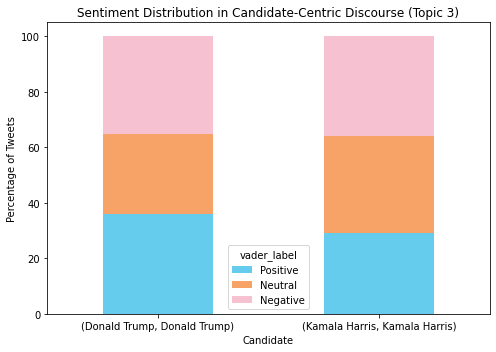

In [65]:

colors = {
    "Positive": "#66CCEE",
    "Neutral": "#F7A267",
    "Negative": "#F6C1D0"
}

sentiment_dist[["Positive", "Neutral", "Negative"]].plot(
    kind="bar",
    stacked=True,
    color=[colors["Positive"], colors["Neutral"], colors["Negative"]],
    figsize=(7,5)
)

plt.title("Sentiment Distribution in Candidate-Centric Discourse (Topic 3)")
plt.ylabel("Percentage of Tweets")
plt.xlabel("Candidate")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### Key Results

- Kamala Harris receives substantially higher tweet volume
- Donald Trump shows slightly higher net sentiment
- Both candidates experience comparable levels of negativity

These results suggest **polarization rather than popularity**, with visibility and sentiment not perfectly aligned.


## B. Volume vs Sentiment Tradeoff

### Research Question

Does higher discussion volume correspond to more positive sentiment?


In [66]:
volume_sentiment = (
    df_candidates
    .groupby("candidate")
    .agg(
        tweet_count=("vader_score", "count"),
        avg_sentiment=("vader_score", "mean")
    )
)

volume_sentiment


,tweet_count,avg_sentiment
candidate,,
Donald Trump,1459,0.018715
Kamala Harris,4676,-0.046457


This analysis reveals a volume–sentiment tradeoff:

1. Kamala Harris is discussed far more frequently, but with slightly more negative sentiment.
2. Donald Trump appears less frequently but receives marginally more positive sentiment on average.

This aligns with political communication research showing that high visibility often attracts criticism, and greater online attention does not necessarily translate to favorable sentiment.

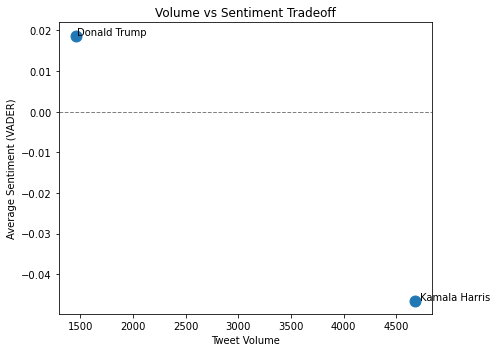

In [67]:
plt.figure(figsize=(7,5))

plt.scatter(
    volume_sentiment["tweet_count"],
    volume_sentiment["avg_sentiment"],
    s=120
)

for candidate in volume_sentiment.index:
    plt.text(
        volume_sentiment.loc[candidate, "tweet_count"] * 1.01,
        volume_sentiment.loc[candidate, "avg_sentiment"],
        candidate
    )

plt.axhline(0, linestyle="--", color="gray", linewidth=1)
plt.xlabel("Tweet Volume")
plt.ylabel("Average Sentiment (VADER)")
plt.title("Volume vs Sentiment Tradeoff")
plt.tight_layout()
plt.show()


### Key Findings

- Kamala Harris dominates discussion volume but exhibits net negative sentiment
- Donald Trump is discussed less but with slightly more positive tone

This highlights a common phenomenon in political discourse:
> High visibility does not imply positive reception.


## C. Topic-Specific Sentiment Analysis

### Research Question

How does sentiment vary across different political discussion themes?


In [68]:
topic_sentiment = (
    df.groupby("lda_topic")["vader_score"]
    .agg(["mean", "std", "count"])
    .rename(columns={"mean": "Mean_Sentiment", "std": "Sentiment_SD"})
)

topic_sentiment


,Mean_Sentiment,Sentiment_SD,count
lda_topic,,,
0,0.060909,0.476677,14232
1,0.091537,0.485591,8569
2,0.091717,0.553786,18032
3,-0.004059,0.455820,9001


In [69]:
topic_dist = (
    df.groupby(["lda_topic", "vader_label"])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum())
    .unstack()
    .fillna(0)
)

topic_dist


,vader_label,Negative,Neutral,Positive
lda_topic,lda_topic,,,
0,0,0.283797,0.335301,0.380902
1,1,0.298518,0.265375,0.436107
2,2,0.371229,0.098547,0.530224
3,3,0.322742,0.355627,0.321631


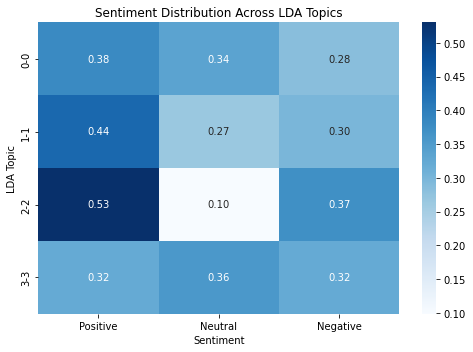

In [70]:
import seaborn as sns

plt.figure(figsize=(7,5))
sns.heatmap(
    topic_dist[["Positive", "Neutral", "Negative"]],
    annot=True,
    fmt=".2f",
    cmap="Blues"
)

plt.title("Sentiment Distribution Across LDA Topics")
plt.xlabel("Sentiment")
plt.ylabel("LDA Topic")
plt.tight_layout()
plt.show()


Topic 2 exhibits the highest positive sentiment concentration (~53%)

Topic 3 (candidate-centric) has:
1. Nearly equal proportions of positive, neutral, and negative sentiment
2. The highest degree of polarization

Interpretation
The data indicates that polarization intensifies when discourse centers on individuals, reinforcing findings in computational political science that candidate-focused narratives amplify emotional responses.

In [71]:
topic_sentiment["Discourse_Type"] = topic_sentiment.index.map(
    lambda x: "Candidate-Centric" if x == 3 else "Ideology / Other"
)

topic_sentiment


,Mean_Sentiment,Sentiment_SD,count,Discourse_Type
lda_topic,,,,
0,0.060909,0.476677,14232,Ideology / Other
1,0.091537,0.485591,8569,Ideology / Other
2,0.091717,0.553786,18032,Ideology / Other
3,-0.004059,0.455820,9001,Candidate-Centric


### Observations

- Ideological topics show higher average positivity
- Candidate-centric discourse exhibits near-neutral mean sentiment
- Negativity is most concentrated in candidate-focused discussions

This indicates that **personalized political discourse attracts more emotional polarization** than abstract ideological debate.


## Key Results

- Twitter political discourse is **highly polarized**
- Candidate visibility and sentiment are weakly correlated
- Sentiment varies substantially by discourse topic
- Topic modeling provides essential context for sentiment analysis

This project demonstrates the importance of **combining topic modeling with sentiment analysis** for meaningful political NLP research.


## Limitations and Future Work

- Twitter users are not representative of the general electorate
- VADER does not fully capture sarcasm or irony
- Topic labels are interpretive and not ground truth

Future extensions may include:
- Temporal sentiment analysis
- Network-based diffusion studies
- Transformer-based sentiment models
